In [1]:
import pandas as pd
from collections import Counter, defaultdict
from biodatatools.utils.common import json_dump
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

# QC metrics

## No. replicates

In [4]:
metafile = f"{PROJECT_DIR_o}tables/SuppTable1.xlsx"

In [6]:
df_exp = pd.read_excel(metafile, sheet_name=1)
df_exp.head(2)

,PRO-cap sample ID,Replicate ID,Replicate Type,Prep time,Procedure,Permeabilized
0,T1D15,T1D15,NaN,NaN,Blood,No
1,T1D18,T1D18,NaN,NaN,Blood,No


In [20]:
# No. replicates per sample

reps = {}
for _, row in df_exp.iterrows():
	reps[row["PRO-cap sample ID"]] = row["Replicate ID"].split(";")

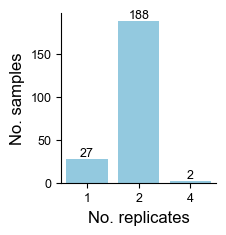

In [24]:
counts = Counter([len(reps[s]) for s in reps])
df = pd.DataFrame(list(counts.items()), columns=["Value", "Count"])
fig, ax = plt.subplots(figsize=(2,2.2))
g = sns.barplot(data=df, x="Value", y="Count", color="skyblue", ax=ax)
for patch in g.patches:
    g.annotate(f'{int(patch.get_height())}', 
                (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                ha='center', va='bottom', fontsize=sfontsize)
g.set_xlabel("No. replicates", fontsize=bfontsize)
g.set_ylabel("No. samples", fontsize=bfontsize)
g.spines[["top", "right"]].set_visible(False)
g.tick_params(labelsize=sfontsize)
plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig1a.pdf", bbox_inches="tight", transparent=True)

## Correlation between replicates

In [7]:
df_metrics = pd.read_excel(metafile, sheet_name=2)
df_metrics.head(2)

,PRO-cap sample ID,Uniquely mapped read pairs,"Uniquely mapped, deduplicated read pairs",Replicate correlation,Median RNA length,Gene body ratio,Divergent elements - Proximal,Divergent elements - Distal Intragenic,Divergent elements - Distal Intergenic,Unidirectional elements - Proximal,Unidirectional elements - Distal Intragenic,Unidirectional elements - Distal Intergenic,Pass
0,T1D15,27966550,18513038.0,NaN,46,0.004971,12809,1354,3424,6299,1149,2695,True
1,T1D18,28540998,17268067.0,NaN,41,0.005483,12803,1312,3133,6024,1243,2883,True


In [25]:
def plot_distribution(values, xlabel, text_x, text_y, outputfile):
	fig, ax = plt.subplots(figsize=(2.8,2))
	g = sns.histplot(values, bins=20, kde=False, color="skyblue", edgecolor="black", ax=ax)
	g.spines[["top", "right"]].set_visible(False)
	g.set_xlabel(xlabel, fontsize=bfontsize)
	g.set_ylabel("No. samples", fontsize=bfontsize)
	g.tick_params(labelsize=sfontsize)
	g.axvline(x=np.median(values), ls="--", c="r")
	g.text(x=text_x, y=text_y, s=f"median={round(np.median(values),3)}", fontsize=sfontsize, c="r")
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

In [26]:
corrs = []
for _, row in df_metrics.iterrows():
	s = row["PRO-cap sample ID"]
	if len(reps[s]) >= 2:
		if type(row["Replicate correlation"]) == str:
			corrs.extend([float(corr) for corr in row["Replicate correlation"].split(";")])
		else:
			corrs.append(row["Replicate correlation"])

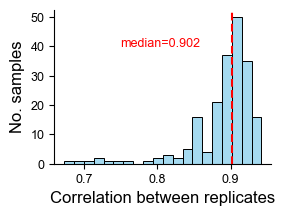

In [32]:
outputfile = f"{PROJECT_DIR_o}figures/SuppFig1b.pdf"
plot_distribution(corrs, "Correlation between replicates", 0.75, 40, outputfile)

## Deduplicated reads

In [35]:
reads = []
for _, row in df_metrics.iterrows():
	if not np.isnan(row["Uniquely mapped, deduplicated read pairs"]):
		reads.append(row["Uniquely mapped, deduplicated read pairs"]/1e6)

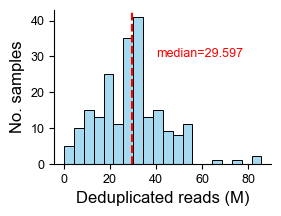

In [36]:
outputfile = f"{PROJECT_DIR_o}figures/SuppFig1c.pdf"
plot_distribution(reads, "Deduplicated reads (M)", 40, 30, outputfile)

## Median RNA length

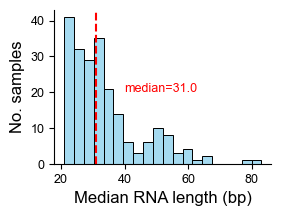

In [39]:
lengths = [row["Median RNA length"] for _, row in df_metrics.iterrows()]
outputfile = f"{PROJECT_DIR_o}figures/SuppFig1d.pdf"
plot_distribution(lengths, "Median RNA length (bp)", 40, 20, outputfile)

## Gene body ratio

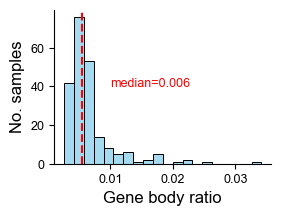

In [38]:
ratios = [row["Gene body ratio"] for _, row in df_metrics.iterrows()]
outputfile = f"{PROJECT_DIR_o}figures/SuppFig1e.pdf"
plot_distribution(ratios, "Gene body ratio", 0.01, 40, outputfile)

# Samples

In [8]:
samples_keep = list(df_metrics[df_metrics["Pass"]!="False"]["PRO-cap sample ID"])
len(samples_keep)

216

In [10]:
df_samples = pd.read_excel(metafile, sheet_name=0)
df_samples.head(2)

,PRO-cap sample ID,Internal group name,Sample name,Sample type,Primary site,Metastatic site,ENCODE Experiment ID,ENCODE Donor ID,ENCODE Biosample ID,GTEx/EN-Tex Donor ID,LeukoPak Donor Collection ID,BROAD Biosample IDs,CHTN/NCI Donor ID,Other collaborators,GEO ID,Age,Gender,Blood Type
0,T1D15,T1D,T cells from T1D donor,Blood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,F,NaN
1,T1D18,T1D,T cells from T1D donor,Blood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,F,NaN


In [40]:
groups = defaultdict(list)
for _, row in df_samples.iterrows():
	s = row["PRO-cap sample ID"]
	if s in samples_keep:
		groups[row["Internal group name"]].append(row["PRO-cap sample ID"])

In [41]:
json_dump(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json", groups)

In [12]:
labels = {}
for _, row in df_samples.iterrows():
	s = row["PRO-cap sample ID"]
	if s in samples_keep:
		if type(row["Primary site"]) == str:
			labels[s] = (row["Primary site"], row["Metastatic site"])
		else:
			labels[s] = (row["Sample name"], row["Sample type"])

In [13]:
json_dump(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json", labels)

In [43]:
cdict = {'Blood': '#3C0949',
		 'Lymph node': '#6a51a3',
		 'Spleen': '#bcbddc',
		 'Brain': '#a6cee3',
		 'Muscle': '#fdb462',
		 'Liver': '#ffde21',
		 'Pancreas': '#238443',
		 'Large intestine': '#78c679',
		 'Small intestine': '#d9f0a3',
		 'Heart': '#fb8072',
		 'Adrenal gland': '#4292c6',
		 'Lung': '#bf812d',
		 'Breast': '#c51b7d',
		 'Ovary': '#969696',
		 'Testis': '#f1b6da'}

In [ ]:
json_dump(f"{PROJECT_DIR_d}PROcap/metainfo/color_codes.json", cdict)